In [118]:
import numpy as np
import argparse
import os
#import imp
import re
import pickle
import datetime
import random
import math
import logging
import copy
import matplotlib.pyplot as plt
import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import kneighbors_graph

from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

import torch
from torch import nn
import torch.nn.utils.rnn as rnn_utils
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn import Parameter

from utils import utils
from utils.readers import InHospitalMortalityReader
from utils.preprocessing import Discretizer, Normalizer
from utils import metrics
from utils import common_utils

In [119]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [120]:
# Load the uploaded datasets
root_path = os.getcwd()
train_dataset = pd.read_excel(root_path + "/data/Tongji/time_series_375_prerpocess_en.xlsx")
test_dataset = pd.read_excel(root_path + "/data/Tongji/time_series_test_110_preprocess_en.xlsx")
def generate_clean_train_dataset(df, feature_list):
    df["PATIENT_ID"] = df["PATIENT_ID"].ffill()
    df = df.loc[:, feature_list].copy()
    df["Admission time"] = pd.to_datetime(df["Admission time"])
    df["Discharge time"] = pd.to_datetime(df["Discharge time"])
    df["t"] = (df["Discharge time"] - df["Admission time"]).dt.days
    t_list = df.groupby("PATIENT_ID")["t"].unique().apply(lambda x: x[0]).tolist()
    outcome_list = df.groupby("PATIENT_ID")["outcome"].unique().apply(lambda x: x[0]).tolist()
    y_target = [min(35, t) if outcome == 0 else 70 - min(35, t) for outcome, t in zip(outcome_list, t_list)]
    return df, y_target

# Prepare the train and test sets
test_features_list = test_dataset.columns.tolist()
X_train, y_train = generate_clean_train_dataset(train_dataset, test_features_list)
X_test, y_test = generate_clean_train_dataset(test_dataset, test_features_list)
# Impute missing values
imputer = KNNImputer(n_neighbors=5)
X_train_numeric = X_train.select_dtypes(include=[np.number])    # remain only columns with numerical data types
X_test_numeric = X_test.select_dtypes(include=[np.number])

X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_numeric), columns=X_train_numeric.columns)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_numeric), columns=X_test_numeric.columns)
# Group by 'PATIENT_ID' to get one row per patient
X_train_final_last = X_train_imputed.groupby("PATIENT_ID").last().reset_index()
X_test_final_last = X_test_imputed.groupby("PATIENT_ID").last().reset_index()
# remove "t" and "outcome", "patientid"
X_train_final = X_train_final_last.drop(columns=["PATIENT_ID","outcome","t"])
X_test_final = X_test_final_last.drop(columns=["PATIENT_ID","outcome","t"])
# Convert features and target to PyTorch tensors
X_train_tensor = torch.tensor(X_train_final.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_final.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
print("X_train_tensor.shape = {}, y_train_tensor.shape = {}, X_test_tensor.shape = {}, y_test_tensor.shape = {}".format(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape))
# DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_train_tensor.shape = torch.Size([375, 3]), y_train_tensor.shape = torch.Size([375, 1]), X_test_tensor.shape = torch.Size([110, 3]), y_test_tensor.shape = torch.Size([110, 1])


In [13]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Model initialization
input_size = X_train_tensor.shape[1]
print("X_train_tesnor.shape = ", X_train_tensor.shape)
model = MLP(input_size)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

# Calculate MSE and MAE on the test set
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = mean_squared_error(y_test_tensor, predictions)
    mae = mean_absolute_error(y_test_tensor, predictions)
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")

X_train_tesnor.shape =  torch.Size([375, 3])
Test MSE: 165.1010
Test MAE: 6.9727


Test MSE: 164.9555
Test MSE: 167.6059
Test MSE: 168.6995
Test MSE: 196.6317
Test MSE: 199.1560


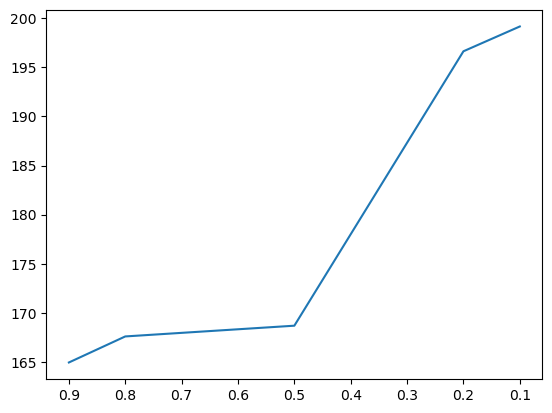

In [44]:
# results 2
# total data
np.random.seed(42)
X_train_final = X_train_final_last.drop(columns=["PATIENT_ID","outcome","t"])
X_test_final = X_test_final_last.drop(columns=["PATIENT_ID","outcome","t"])


def evaluate_different_training_volume(X_train, y_train, X_test, y_test):
    epochs = 200
    batch_size = 32
    pct_list = [0.9, 0.8, 0.5, 0.2, 0.1]

    mse_scores = []

    for i, pct in enumerate(pct_list):
        num_rows = int(pct * len(X_train))
        select_idx = np.random.choice(len(X_train), size=num_rows, replace=False)

        X_train_pct = X_train.sample(frac=pct, replace=False, random_state=42)
        select_idx = X_train_pct.index
        #print(len(select_idx))
        y_train_pct = [y_train[i] for i in select_idx]

        # Convert features and target to PyTorch tensors
        X_train_tensor = torch.tensor(X_train_pct.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_pct, dtype=torch.float32).unsqueeze(1)
        X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

        # DataLoader for training
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        # Model initialization
        input_size = X_train_tensor.shape[1]
        model = MLP(input_size)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                epoch_loss = running_loss / len(train_loader.dataset)
        #print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss:.4f}")

        # Calculate MSE and MAE on the test set
        model.eval()
        with torch.no_grad():
            predictions = model(X_test_tensor)
            mse = mean_squared_error(y_test_tensor, predictions)
            mae = mean_absolute_error(y_test_tensor, predictions)
        print(f"Test MSE: {mse:.4f}")
        #print(f"Test MAE: {mae:.4f}")

        mse_scores.append(mse)

    return pct_list, mse_scores

# Run the evaluation
percentage, mse_scores = evaluate_different_training_volume(X_train_final, y_train, X_test_final, y_test)

plt.plot(percentage, mse_scores)
plt.gca().invert_xaxis()


91
6727


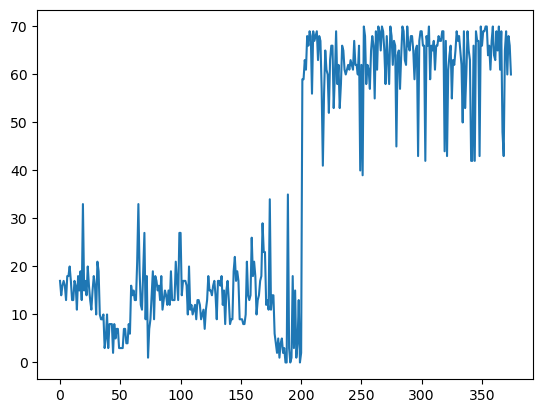

In [17]:
y_tmp = np.array(y_train)
print(y_tmp[y_tmp < 7].sum())
print(y_tmp[y_tmp > 63].sum())
plt.plot(range(len(y_tmp)), y_tmp)

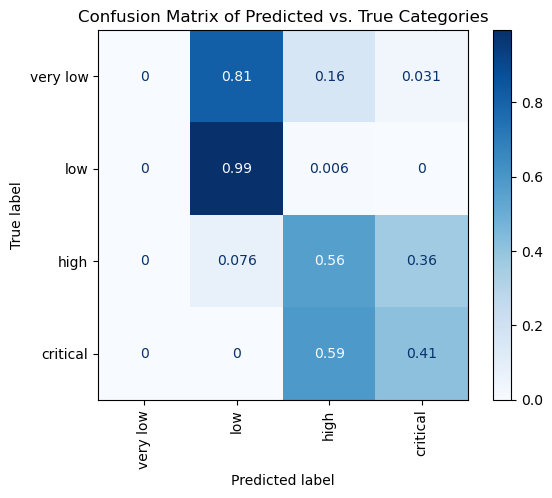

In [19]:
# confusion matrix, result 3
def categorize(y):
    categories = []
    for value in y:
        if value < 7:
            categories.append("very low")
        elif 7 <= value < 35:
            categories.append("low")
        elif 35 <= value < 63:
            categories.append("high")
        else:  # y >= 63
            categories.append("critical")
    return categories

# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_train_tensor)
    predictions = predictions.numpy().flatten()  # Convert to numpy array and flatten
    y_train = y_train_tensor.numpy().flatten()  # Convert target to numpy array and flatten

    # Categorize predictions and true targets
    pred_categories = categorize(predictions)
    true_categories = categorize(y_train)

    # Generate confusion matrix
    cm = confusion_matrix(true_categories, pred_categories, labels=["very low", "low", "high", "critical"])
    cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=["very low", "low", "high", "critical"])
    disp.plot(cmap="Blues", xticks_rotation="vertical")
    plt.title("Confusion Matrix of Predicted vs. True Categories")
    plt.show()


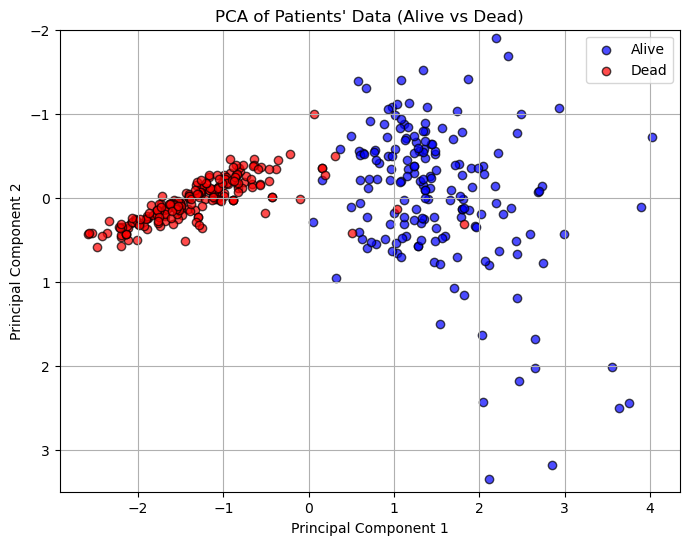

In [20]:
# PCA, result 4
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Group by 'PATIENT_ID' to get one row per patient
X_train_final_last = X_train_imputed.groupby("PATIENT_ID").last().reset_index()
X_test_final_last = X_test_imputed.groupby("PATIENT_ID").last().reset_index()

# remove "t" and "outcome", "patientid"
y_pca = X_train_final_last["outcome"]
X_pca = X_train_final_last.drop(columns=["PATIENT_ID","outcome", "t"])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_pca)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))

# Plot points: Blue for alive (outcome = 1), Red for dead (outcome = 0)
plt.scatter(X_pca[y_pca == 1, 0], X_pca[y_pca == 1, 1], c='blue', label='Alive', edgecolor='k', alpha=0.7)
plt.scatter(X_pca[y_pca == 0, 0], X_pca[y_pca == 0, 1], c='red', label='Dead', edgecolor='k', alpha=0.7)

# Labels and Title
plt.title("PCA of Patients' Data (Alive vs Dead)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="best")
plt.grid(True)
plt.ylim(3.5, -2)
# Show the plot
plt.show()

In [121]:
target_dataset = "TJ"
# Use CUDA if available
device = torch.device("cuda:0" if torch.cuda.is_available() == True else 'cpu')
print("available device: {}".format(device))

available device: cpu


In [122]:
# helper function
def get_loss(y_pred, y_true):
    loss = torch.nn.BCELoss()
    return loss(y_pred, y_true)

def get_re_loss(y_pred, y_true):
    loss = torch.nn.MSELoss()
    return loss(y_pred, y_true)

def get_kl_loss(x_pred, x_target):
    loss = torch.nn.KLDivLoss(reduce=True, size_average=True)
    return loss(x_pred, x_target)

def get_wass_dist(x_pred, x_target):
    m1 = torch.mean(x_pred, dim=0)
    m2 = torch.mean(x_target, dim=0)
    v1 = torch.var(x_pred, dim=0)
    v2 = torch.var(x_target, dim=0)
    p1 = torch.sum(torch.pow((m1 - m2), 2))
    p2 = torch.sum(torch.pow(torch.pow(v1, 1/2) - torch.pow(v2, 1/2), 2))
    return torch.pow(p1+p2, 1/2)

def pad_sents(sents, pad_token):

    sents_padded = []

    max_length = max([len(_) for _ in sents])
    for i in sents:
        padded = list(i) + [pad_token]*(max_length-len(i))
        sents_padded.append(np.array(padded))
    return np.array(sents_padded)

def batch_iter(x, y, mask, lens, batch_size, shuffle=False):
    """ Yield batches of source and target sentences reverse sorted by length (largest to smallest).
    @param data (list of (src_sent, tgt_sent)): list of tuples containing source and target sentence
    @param batch_size (int): batch size
    @param shuffle (boolean): whether to randomly shuffle the dataset
    """
    batch_num = math.ceil(len(x) / batch_size) # 向下取整
    index_array = list(range(len(x)))

    if shuffle:
        np.random.shuffle(index_array)

    for i in range(batch_num):
        indices = index_array[i * batch_size: (i + 1) * batch_size] #  fetch out all the induces
        
        examples = []
        for idx in indices:
            examples.append((x[idx], y[idx], mask[idx], lens[idx]))
       
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)
    
        batch_x = [e[0] for e in examples]
        batch_y = [e[1] for e in examples]
        batch_mask_x = [e[2] for e in examples]
#         batch_name = [e[2] for e in examples]
        batch_lens = [e[3] for e in examples]

        yield batch_x, batch_y, batch_mask_x, batch_lens

def length_to_mask(length, max_len=None, dtype=None):
    """length: B.
    return B x max_len.
    If max_len is None, then max of length will be used.
    """
    assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
    max_len = max_len or length.max().item()
    mask = torch.arange(max_len, device=length.device,
                        dtype=length.dtype).expand(len(length), max_len) < length.unsqueeze(1)
    if dtype is not None:
        mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
    return mask

# helper function to print out dataset info
def print_data_info(dataset, name = "undefined"):
    print("tjh {} data has {} record lines".format(name, dataset.shape[0]))
    print("tjh {} data has {} unique Patient_ID".format(name, len(dataset["PATIENT_ID"].dropna().unique())))
    print("tjh {} data has {} features, including PATIENT_ID".format(name, dataset.shape[1]))

In [123]:
class SingleAttention(nn.Module):
    def __init__(self, attention_input_dim, attention_hidden_dim, attention_type='add', demographic_dim=12, time_aware=False, use_demographic=False):
        super(SingleAttention, self).__init__()
        
        self.attention_type = attention_type
        self.attention_hidden_dim = attention_hidden_dim
        self.attention_input_dim = attention_input_dim
        self.use_demographic = use_demographic
        self.demographic_dim = demographic_dim
        self.time_aware = time_aware

        # batch_time = torch.arange(0, batch_mask.size()[1], dtype=torch.float32).reshape(1, batch_mask.size()[1], 1)
        # batch_time = batch_time.repeat(batch_mask.size()[0], 1, 1)
        
        if attention_type == 'add':
            if self.time_aware == True:
                # self.Wx = nn.Parameter(torch.randn(attention_input_dim+1, attention_hidden_dim))
                self.Wx = nn.Parameter(torch.randn(attention_input_dim, attention_hidden_dim))
                self.Wtime_aware = nn.Parameter(torch.randn(1, attention_hidden_dim))
                nn.init.kaiming_uniform_(self.Wtime_aware, a=math.sqrt(5))
            else:
                self.Wx = nn.Parameter(torch.randn(attention_input_dim, attention_hidden_dim))
            self.Wt = nn.Parameter(torch.randn(attention_input_dim, attention_hidden_dim))
            self.Wd = nn.Parameter(torch.randn(demographic_dim, attention_hidden_dim))
            self.bh = nn.Parameter(torch.zeros(attention_hidden_dim,))
            self.Wa = nn.Parameter(torch.randn(attention_hidden_dim, 1))
            self.ba = nn.Parameter(torch.zeros(1,))
            
            nn.init.kaiming_uniform_(self.Wd, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wx, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wt, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        elif attention_type == 'mul':
            self.Wa = nn.Parameter(torch.randn(attention_input_dim, attention_input_dim))
            self.ba = nn.Parameter(torch.zeros(1,))
            
            nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        elif attention_type == 'concat':
            if self.time_aware == True:
                self.Wh = nn.Parameter(torch.randn(2*attention_input_dim+1, attention_hidden_dim))
            else:
                self.Wh = nn.Parameter(torch.randn(2*attention_input_dim, attention_hidden_dim))

            self.Wa = nn.Parameter(torch.randn(attention_hidden_dim, 1))
            self.ba = nn.Parameter(torch.zeros(1,))
            
            nn.init.kaiming_uniform_(self.Wh, a=math.sqrt(5))
            nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        else:
            raise RuntimeError('Wrong attention type.')
        
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
    
    def forward(self, input, demo=None):
 
        batch_size, time_step, input_dim = input.size() # batch_size * time_step * hidden_dim(i)
        time_decays = torch.tensor(range(time_step-1,-1,-1), dtype=torch.float32).unsqueeze(-1).unsqueeze(0).to(device)# 1*t*1
        b_time_decays = time_decays.repeat(batch_size,1,1)# b t 1
        
        if self.attention_type == 'add': #B*T*I  @ H*I
            q = torch.matmul(input[:,-1,:], self.Wt)# b h
            q = torch.reshape(q, (batch_size, 1, self.attention_hidden_dim)) #B*1*H
            if self.time_aware == True:
                # k_input = torch.cat((input, time), dim=-1)
                k = torch.matmul(input, self.Wx)#b t h
                # k = torch.reshape(k, (batch_size, 1, time_step, self.attention_hidden_dim)) #B*1*T*H
                time_hidden = torch.matmul(b_time_decays, self.Wtime_aware)#  b t h
            else:
                k = torch.matmul(input, self.Wx)# b t h
                # k = torch.reshape(k, (batch_size, 1, time_step, self.attention_hidden_dim)) #B*1*T*H
            if self.use_demographic == True:
                d = torch.matmul(demo, self.Wd) #B*H
                d = torch.reshape(d, (batch_size, 1, self.attention_hidden_dim)) # b 1 h
            h = q + k + self.bh # b t h
            if self.time_aware == True:
                h += time_hidden
            h = self.tanh(h) #B*T*H
            e = torch.matmul(h, self.Wa) + self.ba #B*T*1
            e = torch.reshape(e, (batch_size, time_step))# b t
        elif self.attention_type == 'mul':
            e = torch.matmul(input[:,-1,:], self.Wa)#b i
            e = torch.matmul(e.unsqueeze(1), input.permute(0,2,1)).squeeze() + self.ba #b t
        elif self.attention_type == 'concat':
            q = input[:,-1,:].unsqueeze(1).repeat(1,time_step,1)# b t i
            k = input
            c = torch.cat((q, k), dim=-1) #B*T*2I
            if self.time_aware == True:
                c = torch.cat((c, b_time_decays), dim=-1) #B*T*2I+1
            h = torch.matmul(c, self.Wh)
            h = self.tanh(h)
            e = torch.matmul(h, self.Wa) + self.ba #B*T*1
            e = torch.reshape(e, (batch_size, time_step)) # b t 
        
        a = self.softmax(e) #B*T
        v = torch.matmul(a.unsqueeze(1), input).squeeze() #B*I

        return v, a

class FinalAttentionQKV(nn.Module):
    def __init__(self, attention_input_dim, attention_hidden_dim, attention_type='add', dropout=None):
        super(FinalAttentionQKV, self).__init__()
        
        self.attention_type = attention_type
        self.attention_hidden_dim = attention_hidden_dim
        self.attention_input_dim = attention_input_dim


        self.W_q = nn.Linear(attention_input_dim, attention_hidden_dim)
        self.W_k = nn.Linear(attention_input_dim, attention_hidden_dim)
        self.W_v = nn.Linear(attention_input_dim, attention_hidden_dim)

        self.W_out = nn.Linear(attention_hidden_dim, 1)

        self.b_in = nn.Parameter(torch.zeros(1,))
        self.b_out = nn.Parameter(torch.zeros(1,))

        nn.init.kaiming_uniform_(self.W_q.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_k.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_v.weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.W_out.weight, a=math.sqrt(5))

        self.Wh = nn.Parameter(torch.randn(2*attention_input_dim, attention_hidden_dim))
        self.Wa = nn.Parameter(torch.randn(attention_hidden_dim, 1))
        self.ba = nn.Parameter(torch.zeros(1,))
        
        nn.init.kaiming_uniform_(self.Wh, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.Wa, a=math.sqrt(5))
        
        self.dropout = nn.Dropout(p=dropout)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, input):
 
        batch_size, time_step, input_dim = input.size() # batch_size * input_dim + 1 * hidden_dim(i)
        input_q = self.W_q(torch.mean(input, dim=1)) # b h
        input_k = self.W_k(input)# b t h
        input_v = self.W_v(input)# b t h

        if self.attention_type == 'add': #B*T*I  @ H*I

            q = torch.reshape(input_q, (batch_size, 1, self.attention_hidden_dim)) #B*1*H
            h = q + input_k + self.b_in # b t h
            h = self.tanh(h) #B*T*H
            e = self.W_out(h) # b t 1
            e = torch.reshape(e, (batch_size, time_step))# b t

        elif self.attention_type == 'mul':
            q = torch.reshape(input_q, (batch_size, self.attention_hidden_dim, 1)) #B*h 1
            e = torch.matmul(input_k, q).squeeze()#b t
            
        elif self.attention_type == 'concat':
            q = input_q.unsqueeze(1).repeat(1,time_step,1)# b t h
            k = input_k
            c = torch.cat((q, k), dim=-1) #B*T*2I
            h = torch.matmul(c, self.Wh)
            h = self.tanh(h)
            e = torch.matmul(h, self.Wa) + self.ba #B*T*1
            e = torch.reshape(e, (batch_size, time_step)) # b t 
        
        a = self.softmax(e) #B*T
        if self.dropout is not None:
            a = self.dropout(a)
        v = torch.matmul(a.unsqueeze(1), input_v).squeeze() #B*I

        return v, a

def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def tile(a, dim, n_tile):
    init_dim = a.size(dim)
    repeat_idx = [1] * a.dim()
    repeat_idx[dim] = n_tile
    a = a.repeat(*(repeat_idx))
    order_index = torch.LongTensor(np.concatenate([init_dim * np.arange(n_tile) + i for i in range(init_dim)])).to(device)
    return torch.index_select(a, dim, order_index).to(device)

class PositionwiseFeedForward(nn.Module): # new added
    "Implements FFN equation."
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x)))), None

    
class PositionalEncoding(nn.Module): # new added / not use anymore
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=400):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0., max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0., d_model, 2) * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + Variable(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0 

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)# b h t d_k
    scores = torch.matmul(query, key.transpose(-2, -1)) \
             / math.sqrt(d_k) # b h t t
    if mask is not None:# 1 1 t t
        scores = scores.masked_fill(mask == 0, -1e9)# b h t t 
    p_attn = F.softmax(scores, dim = -1)# b h t t
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn # b h t v (d_k) 
    
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, self.d_k * self.h), 3)
        self.final_linear = nn.Linear(d_model, d_model)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1) # 1 1 t t

        nbatches = query.size(0)# b
        input_dim = query.size(1)# i+1
        feature_dim = query.size(-1)# i+1

        #input size -> # batch_size * d_input * hidden_dim
        
        # d_model => h * d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))] # b num_head d_input d_k
        
       
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)# b num_head d_input d_v (d_k) 
        
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)# batch_size * d_input * hidden_dim

        #DeCov 
        DeCov_contexts = x.transpose(0, 1).transpose(1, 2) # I+1 H B
#         print(DeCov_contexts.shape)
        Covs = cov(DeCov_contexts[0,:,:])
        DeCov_loss = 0.5 * (torch.norm(Covs, p = 'fro')**2 - torch.norm(torch.diag(Covs))**2 ) 
        for i in range(2):
            Covs = cov(DeCov_contexts[i+1,:,:])
            DeCov_loss += 0.5 * (torch.norm(Covs, p = 'fro')**2 - torch.norm(torch.diag(Covs))**2 ) 


        return self.final_linear(x), DeCov_loss

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-7):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        #print("self.a_2.shape = ", self.a_2.shape)
        #print("x.shape = ", x.shape)
        #print("self.b_2.shape = ", self.b_2.shape)

        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

def cov(m, y=None):
    if y is not None:
        m = torch.cat((m, y), dim=0)
    m_exp = torch.mean(m, dim=1)
    x = m - m_exp[:, None]
    cov = 1 / (x.size(1) - 1) * x.mm(x.t())
    return cov

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        returned_value = sublayer(self.norm(x))
        return x + self.dropout(returned_value[0]) , returned_value[1]

In [124]:
# teacher model
class distcare_teacher(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_model,  MHD_num_head, d_ff, output_dim, keep_prob=0.5):
        super(distcare_teacher, self).__init__()
        # hyperparameters
        self.input_dim = input_dim  
        self.hidden_dim = hidden_dim  # d_model
        self.d_model = d_model
        self.MHD_num_head = MHD_num_head
        self.d_ff = d_ff
        self.output_dim = output_dim
        self.keep_prob = keep_prob

        # layers
        self.PositionalEncoding = PositionalEncoding(self.d_model, dropout = 0, max_len = 400)

        self.GRUs = clones(nn.GRU(1, self.hidden_dim, batch_first = True), self.input_dim)
        self.LastStepAttentions = clones(SingleAttention(self.hidden_dim, 8, attention_type='concat', demographic_dim=12, time_aware=True, use_demographic=False),self.input_dim)
        
        self.FinalAttentionQKV = FinalAttentionQKV(self.hidden_dim, self.hidden_dim, attention_type='mul',dropout = 1 - self.keep_prob)

        self.MultiHeadedAttention = MultiHeadedAttention(self.MHD_num_head, self.d_model,dropout = 1 - self.keep_prob)
        self.SublayerConnection = SublayerConnection(self.d_model, dropout = 1 - self.keep_prob)

        self.PositionwiseFeedForward = PositionwiseFeedForward(self.d_model, self.d_ff, dropout=0.1)

        self.demo_proj_main = nn.Linear(12, self.hidden_dim)
        self.demo_proj = nn.Linear(12, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)

        self.dropout = nn.Dropout(p = 1 - self.keep_prob)
        self.tanh=nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()

    def forward(self, input, lens):
        # input shape [batch_size, timestep, feature_dim]
#         demo_main = self.tanh(self.demo_proj_main(demo_input)).unsqueeze(1)# b hidden_dim
        
        batch_size = input.size(0)
        time_step = input.size(1)
        feature_dim = input.size(2)
        assert(feature_dim == self.input_dim)# input Tensor : 256 * 48 * 76
        assert(self.d_model % self.MHD_num_head == 0)
        
        GRU_embeded_input = self.GRUs[0](pack_padded_sequence(input[:,:,0].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
#         print(GRU_embeded_input.shape)
        for i in range(feature_dim-1):
            embeded_input = self.GRUs[i+1](pack_padded_sequence(input[:,:,i+1].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
            GRU_embeded_input = torch.cat((GRU_embeded_input, embeded_input), 1)
#         GRU_embeded_input = torch.cat((GRU_embeded_input, demo_main), 1)# b i+1 h
        posi_input = self.dropout(GRU_embeded_input) # batch_size * d_input * hidden_dim
        #mask = subsequent_mask(time_step).to(device) # 1 t t 
        contexts = self.SublayerConnection(posi_input, lambda x: self.MultiHeadedAttention(posi_input, posi_input, posi_input, None))# # batch_size * d_input * hidden_dim
    
        DeCov_loss = contexts[1]
        contexts = contexts[0]

        contexts = self.SublayerConnection(contexts, lambda x: self.PositionwiseFeedForward(contexts))[0]# # batch_size * d_input * hidden_dim

        weighted_contexts = self.FinalAttentionQKV(contexts)[0]
        output = self.output(self.dropout(weighted_contexts))# b 1
        output = self.sigmoid(output)
          
        return output, DeCov_loss  ,weighted_contexts

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED) #numpy
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) # cpu
torch.cuda.manual_seed(RANDOM_SEED) #gpu
torch.backends.cudnn.deterministic=True # cudnn
    
epochs = 150
batch_size = 256
input_dim = 34
hidden_dim = 32
d_model = 32
MHD_num_head = 4
d_ff = 64
output_dim = 1

model = distcare_teacher(input_dim = input_dim, hidden_dim = hidden_dim, d_model=d_model, MHD_num_head=MHD_num_head, d_ff=d_ff, output_dim = output_dim).to(device)
# input_dim, d_model, d_k, d_v, MHD_num_head, d_ff, output_dim
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [125]:
if target_dataset == 'TJ':    
    file_name = './model/pretrained-challenge-front-fill-teacher-2covid'
    
checkpoint = torch.load(file_name, \
                        map_location=torch.device("cuda:0" if torch.cuda.is_available() == True else 'cpu') )
save_epoch = checkpoint['epoch']
print("last saved model is in epoch {}".format(save_epoch))
model.load_state_dict(checkpoint['net'])
optimizer.load_state_dict(checkpoint['optimizer'])
model.eval()

last saved model is in epoch 83


distcare_teacher(
  (PositionalEncoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (GRUs): ModuleList(
    (0-33): 34 x GRU(1, 32, batch_first=True)
  )
  (LastStepAttentions): ModuleList(
    (0-33): 34 x SingleAttention(
      (tanh): Tanh()
      (softmax): Softmax(dim=None)
    )
  )
  (FinalAttentionQKV): FinalAttentionQKV(
    (W_q): Linear(in_features=32, out_features=32, bias=True)
    (W_k): Linear(in_features=32, out_features=32, bias=True)
    (W_v): Linear(in_features=32, out_features=32, bias=True)
    (W_out): Linear(in_features=32, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (tanh): Tanh()
    (softmax): Softmax(dim=None)
    (sigmoid): Sigmoid()
  )
  (MultiHeadedAttention): MultiHeadedAttention(
    (linears): ModuleList(
      (0-2): 3 x Linear(in_features=32, out_features=32, bias=True)
    )
    (final_linear): Linear(in_features=32, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
 

In [126]:
# student model
class distcare_student(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_model,  MHD_num_head, d_ff, output_dim, keep_prob=0.5):
        super(distcare_student, self).__init__()

        # hyperparameters
        self.input_dim = input_dim  
        self.hidden_dim = hidden_dim  # d_model
        self.d_model = d_model
        self.MHD_num_head = MHD_num_head
        self.d_ff = d_ff
        self.output_dim = output_dim
        self.keep_prob = keep_prob

        # layers
        self.PositionalEncoding = PositionalEncoding(self.d_model, dropout = 0, max_len = 400)

        self.GRUs = clones(nn.GRU(1, self.hidden_dim, batch_first = True), self.input_dim)
        self.LastStepAttentions = clones(SingleAttention(self.hidden_dim, 8, attention_type='concat', demographic_dim=12, time_aware=True, use_demographic=False),self.input_dim)
        
        self.FinalAttentionQKV = FinalAttentionQKV(self.hidden_dim, self.hidden_dim, attention_type='mul',dropout = 1 - self.keep_prob)

        self.MultiHeadedAttention = MultiHeadedAttention(self.MHD_num_head, self.d_model,dropout = 1 - self.keep_prob)
        self.SublayerConnection = SublayerConnection(self.d_model, dropout = 1 - self.keep_prob)

        self.PositionwiseFeedForward = PositionwiseFeedForward(self.d_model, self.d_ff, dropout=0.1)

        self.demo_proj_main = nn.Linear(12, self.hidden_dim)
        self.demo_proj = nn.Linear(12, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)

        self.dropout = nn.Dropout(p = 1 - self.keep_prob)
        self.FC_embed = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.tanh=nn.Tanh()
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()

    def forward(self, input, lens):
        # input shape [batch_size, timestep, feature_dim]
#         demo_main = self.tanh(self.demo_proj_main(demo_input)).unsqueeze(1)# b hidden_dim    
        batch_size = input.size(0)
        time_step = input.size(1)
        feature_dim = input.size(2)
        assert(feature_dim == self.input_dim)# input Tensor : 256 * 48 * 76
        assert(self.d_model % self.MHD_num_head == 0)

#         input = pack_padded_sequence(input, lens, batch_first=True)
        
        GRU_embeded_input = self.GRUs[0](pack_padded_sequence(input[:,:,0].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
#         print(GRU_embeded_input.shape)
        for i in range(feature_dim-1):
            embeded_input = self.GRUs[i+1](pack_padded_sequence(input[:,:,i+1].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
            GRU_embeded_input = torch.cat((GRU_embeded_input, embeded_input), 1)

#         GRU_embeded_input = torch.cat((GRU_embeded_input, demo_main), 1)# b i+1 h
        posi_input = self.dropout(GRU_embeded_input) # batch_size * d_input * hidden_dim
        #mask = subsequent_mask(time_step).to(device) # 1 t t 下三角 N to 1任务不用mask
        contexts = self.SublayerConnection(posi_input, lambda x: self.MultiHeadedAttention(posi_input, posi_input, posi_input, None))# # batch_size * d_input * hidden_dim
    
        DeCov_loss = contexts[1]
        contexts = contexts[0]

        contexts = self.SublayerConnection(contexts, lambda x: self.PositionwiseFeedForward(contexts))[0]# # batch_size * d_input * hidden_dim

        weighted_contexts = self.FinalAttentionQKV(contexts)[0]
        output_embed = self.FC_embed(weighted_contexts)
        output = self.output(self.dropout(weighted_contexts))# b 1
        output = self.sigmoid(output)
#         print(weighted_contexts.shape)
          
        return output, DeCov_loss  ,output_embed
    #, self.MultiHeadedAttention.attn


# target dataset is TJ
subset_idx = [27, 29, 18, 16, 26, 33, 28, 31, 32, 15, 11, 25, 21, 20, 9, 17, 30, 19]
subset_cnt = len(subset_idx)
epochs = 150
batch_size = 256
input_dim = subset_cnt
hidden_dim = 32
d_model = 32
MHD_num_head = 4
d_ff = 64
output_dim = 1

model_student = distcare_student(input_dim = input_dim, hidden_dim = hidden_dim, d_model=d_model, MHD_num_head=MHD_num_head, d_ff=d_ff, output_dim = output_dim).to(device)
# input_dim, d_model, d_k, d_v, MHD_num_head, d_ff, output_dim
optimizer_student = torch.optim.Adam(model_student.parameters(), lr=1e-3)


## load pre-trained student model
teacher_flag = False

if target_dataset == 'TJ':    
    data_str = 'covid'
if teacher_flag:
    file_name = './model/pretrained-challenge-front-fill-2'+ data_str
else: 
    file_name = './model/pretrained-challenge-front-fill-2'+ data_str + '-noteacher'

checkpoint = torch.load(file_name, \
                        map_location=torch.device("cuda:0" if torch.cuda.is_available() == True else 'cpu') )
save_epoch = checkpoint['epoch']
print("last saved model is in epoch {}".format(save_epoch))
model_student.load_state_dict(checkpoint['net'])
optimizer_student.load_state_dict(checkpoint['optimizer'])
model_student.eval()

last saved model is in epoch 189


distcare_student(
  (PositionalEncoding): PositionalEncoding(
    (dropout): Dropout(p=0, inplace=False)
  )
  (GRUs): ModuleList(
    (0-17): 18 x GRU(1, 32, batch_first=True)
  )
  (LastStepAttentions): ModuleList(
    (0-17): 18 x SingleAttention(
      (tanh): Tanh()
      (softmax): Softmax(dim=None)
    )
  )
  (FinalAttentionQKV): FinalAttentionQKV(
    (W_q): Linear(in_features=32, out_features=32, bias=True)
    (W_k): Linear(in_features=32, out_features=32, bias=True)
    (W_v): Linear(in_features=32, out_features=32, bias=True)
    (W_out): Linear(in_features=32, out_features=1, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
    (tanh): Tanh()
    (softmax): Softmax(dim=None)
    (sigmoid): Sigmoid()
  )
  (MultiHeadedAttention): MultiHeadedAttention(
    (linears): ModuleList(
      (0-2): 3 x Linear(in_features=32, out_features=32, bias=True)
    )
    (final_linear): Linear(in_features=32, out_features=32, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
 

## target model

In [127]:
class distcare_target(nn.Module):
    def __init__(self, input_dim, hidden_dim, d_model,  MHD_num_head, d_ff, output_dim, keep_prob=0.5):
        super(distcare_target, self).__init__()
        # hyperparameters
        self.input_dim = input_dim  
        self.hidden_dim = hidden_dim  # d_model
        self.d_model = d_model
        self.MHD_num_head = MHD_num_head
        self.d_ff = d_ff
        self.output_dim = output_dim
        self.keep_prob = keep_prob
        # layers
        self.PositionalEncoding = PositionalEncoding(self.d_model, dropout = 0, max_len = 400)
        self.GRUs = clones(nn.GRU(1, self.hidden_dim, batch_first = True), self.input_dim)
        self.LastStepAttentions = clones(SingleAttention(self.hidden_dim, 16, attention_type='concat', demographic_dim=12, time_aware=True, use_demographic=False),self.input_dim)
        self.FinalAttentionQKV = FinalAttentionQKV(self.hidden_dim, self.hidden_dim, attention_type='mul',dropout = 1 - self.keep_prob)
        self.MultiHeadedAttention = MultiHeadedAttention(self.MHD_num_head, self.d_model,dropout = 1 - self.keep_prob)
        self.SublayerConnection = SublayerConnection(self.d_model, dropout = 1 - self.keep_prob)
        self.PositionwiseFeedForward = PositionwiseFeedForward(self.d_model, self.d_ff, dropout=0.1)
        self.demo_proj_main = nn.Linear(12, self.hidden_dim)
        self.demo_proj = nn.Linear(12, self.hidden_dim)
        self.output = nn.Linear(self.hidden_dim, self.output_dim)
        self.dropout = nn.Dropout(p = 1 - self.keep_prob)
        self.FC_embed = nn.Linear(self.hidden_dim, self.hidden_dim)
        self.tanh=nn.Tanh()
        self.MLP = nn.Sequential(
            nn.Linear(self.hidden_dim, 8),
            nn.ReLU(),
            nn.Linear(8, self.output_dim)
        )
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU()

    def forward(self, input, lens):
        # input shape [batch_size, timestep, feature_dim]
#         demo_main = self.tanh(self.demo_proj_main(demo_input)).unsqueeze(1)# b hidden_dim
        batch_size = input.size(0)
        time_step = input.size(1)
        feature_dim = input.size(2)
        #print("feature_dim = ", feature_dim)
        assert(feature_dim == self.input_dim)# input Tensor : 256 * 48 * 76
        assert(self.d_model % self.MHD_num_head == 0)   
        GRU_embeded_input = self.GRUs[0](pack_padded_sequence(input[:,:,0].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
#         print(GRU_embeded_input.shape)
        for i in range(feature_dim-1):
            embeded_input = self.GRUs[i+1](pack_padded_sequence(input[:,:,i+1].unsqueeze(-1), lens, batch_first=True))[1].squeeze().unsqueeze(1) # b 1 h
            GRU_embeded_input = torch.cat((GRU_embeded_input, embeded_input), 1)
#         GRU_embeded_input = torch.cat((GRU_embeded_input, demo_main), 1)# b i+1 h
        posi_input = self.dropout(GRU_embeded_input) # batch_size * d_input * hidden_dim
        #mask = subsequent_mask(time_step).to(device) # 1 t t 下三角 N to 1任务不用mask
        contexts = self.SublayerConnection(posi_input, lambda x: self.MultiHeadedAttention(posi_input, posi_input, posi_input, None))# # batch_size * d_input * hidden_dim
        DeCov_loss = contexts[1]
        contexts = contexts[0]
        contexts = self.SublayerConnection(contexts, lambda x: self.PositionwiseFeedForward(contexts))[0]# # batch_size * d_input * hidden_dim
        weighted_contexts = self.FinalAttentionQKV(contexts)[0]
        #output_embed = self.FC_embed(weighted_contexts)
        output = self.MLP(self.dropout(weighted_contexts))# b 1
        if self.output_dim != 1:
            output = F.softmax(output, dim=1)
#         print(weighted_contexts.shape)
        return output, DeCov_loss  ,weighted_contexts
    #, self.MultiHeadedAttention.attn

def transfer_gru_dict(pretrain_dict, model_dict):
    state_dict = {}
    for k, v in pretrain_dict.items():
        if 'GRUs' in k:
            state_dict[k] = v
            print("transfered weight: {}".format(k))
        else:
            print("Other weight in model_dict: {}".format(k))
    return state_dict

teacher_flag = True
transfer_flag = True

# transfer weightes from pre-train student model to target model
if transfer_flag:
        checkpoint = torch.load(file_name, \
                        map_location=torch.device("cuda:0" if torch.cuda.is_available() == True else 'cpu'))
        pretrain_dict = checkpoint['net']
        model_dict = model.state_dict()
        pretrain_dict = transfer_gru_dict(pretrain_dict, model_dict)
        model_dict.update(pretrain_dict)
        model.load_state_dict(model_dict)

Other weight in model_dict: PositionalEncoding.pe
transfered weight: GRUs.0.weight_ih_l0
transfered weight: GRUs.0.weight_hh_l0
transfered weight: GRUs.0.bias_ih_l0
transfered weight: GRUs.0.bias_hh_l0
transfered weight: GRUs.1.weight_ih_l0
transfered weight: GRUs.1.weight_hh_l0
transfered weight: GRUs.1.bias_ih_l0
transfered weight: GRUs.1.bias_hh_l0
transfered weight: GRUs.2.weight_ih_l0
transfered weight: GRUs.2.weight_hh_l0
transfered weight: GRUs.2.bias_ih_l0
transfered weight: GRUs.2.bias_hh_l0
transfered weight: GRUs.3.weight_ih_l0
transfered weight: GRUs.3.weight_hh_l0
transfered weight: GRUs.3.bias_ih_l0
transfered weight: GRUs.3.bias_hh_l0
transfered weight: GRUs.4.weight_ih_l0
transfered weight: GRUs.4.weight_hh_l0
transfered weight: GRUs.4.bias_ih_l0
transfered weight: GRUs.4.bias_hh_l0
transfered weight: GRUs.5.weight_ih_l0
transfered weight: GRUs.5.weight_hh_l0
transfered weight: GRUs.5.bias_ih_l0
transfered weight: GRUs.5.bias_hh_l0
transfered weight: GRUs.6.weight_ih_l0

In [169]:
cell = 'GRU'
hidden_dim = 32
d_model = 32
MHD_num_head = 4
d_ff = 3
output_dim = 1
RANDOM_SEED = 42

In [191]:
# reshpae input size to use pre-trained target model
X_train_final = X_train_final_last.drop(columns=["PATIENT_ID","outcome","t"]).values
X_test_final = X_test_final_last.drop(columns=["PATIENT_ID","outcome","t"]).values

X_train_ts = X_train_final.reshape(-1, 1, 3)  # Reshape X to [375, 1, 3]
X_test_ts = X_test_final.reshape(-1, 1, 3)

# Convert features and target to PyTorch tensors
X_train_tensor = torch.tensor(X_train_ts, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_ts, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)
print("X_train_tensor.shape = {}, y_train_tensor.shape = {}, X_test_tensor.shape = {}, y_test_tensor.shape = {}".format(X_train_tensor.shape, y_train_tensor.shape, X_test_tensor.shape, y_test_tensor.shape))


X_train_tensor.shape = torch.Size([375, 1, 3]), y_train_tensor.shape = torch.Size([375, 1]), X_test_tensor.shape = torch.Size([110, 1, 3]), y_test_tensor.shape = torch.Size([110, 1])


In [239]:
# our train / test on DistCare Target model
# result 1
epochs = 200
batch_size = 32

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

model = distcare_target(input_dim = 3,output_dim=output_dim, d_model=d_model, MHD_num_head=MHD_num_head, d_ff=d_ff, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(epochs):
    model.train()
    running_loss =0.0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        batch_x = inputs
        batch_y = targets
        batch_lens = torch.ones(batch_x.size(0), dtype=torch.int64)  # Shape: [number_instances]

        masks = length_to_mask(batch_lens).unsqueeze(-1).float()
        
        opt, decov_loss, emb = model(batch_x, batch_lens)

        MSE_Loss = get_re_loss(opt, batch_y.unsqueeze(-1))

        model_loss =  MSE_Loss + 1e7*decov_loss

        loss = model_loss

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
#print("train mse = ", epoch_loss / X_train_tensor.shape[0])

# evaluation on test dataset
model.eval()
lens = torch.ones(X_test_tensor.size(0), dtype=torch.int64)  # Shape: [number_instances]
# Inference using the DataLoader
with torch.no_grad():
    outputs, decov_loss, weighted_contexts = model(X_test_tensor, lens)
    mse = mean_squared_error(y_test_tensor, outputs)
    mae = mean_absolute_error(y_test_tensor, outputs)
print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

/var/folders/r2/81fh0cdj25s4vdzcr3g1sldm0000gn/T/ipykernel_1745/4011958756.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = self.softmax(e) #B*T
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([23, 1, 1])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 305.8588
Test MAE: 16.4427


/var/folders/r2/81fh0cdj25s4vdzcr3g1sldm0000gn/T/ipykernel_1745/4011958756.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = self.softmax(e) #B*T
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([18, 1, 1])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 358.9818
Test MAE: 12.0530


/var/folders/r2/81fh0cdj25s4vdzcr3g1sldm0000gn/T/ipykernel_1745/4011958756.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = self.softmax(e) #B*T
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([12, 1, 1])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 366.6326
Test MAE: 12.3611


/var/folders/r2/81fh0cdj25s4vdzcr3g1sldm0000gn/T/ipykernel_1745/4011958756.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = self.softmax(e) #B*T
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([28, 1, 1])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 420.6231
Test MAE: 14.3661


/var/folders/r2/81fh0cdj25s4vdzcr3g1sldm0000gn/T/ipykernel_1745/4011958756.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = self.softmax(e) #B*T
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([11, 1, 1])) that is different to the input size (torch.Size([11, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 477.3040
Test MAE: 16.2193


/var/folders/r2/81fh0cdj25s4vdzcr3g1sldm0000gn/T/ipykernel_1745/4011958756.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = self.softmax(e) #B*T
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1, 1])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/bofan/miniconda3/envs/bf-projects/lib/python3.8/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([6, 1, 1])) that is different to the input size (torch.Size([6, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Test MSE: 643.6063
Test MAE: 20.7642


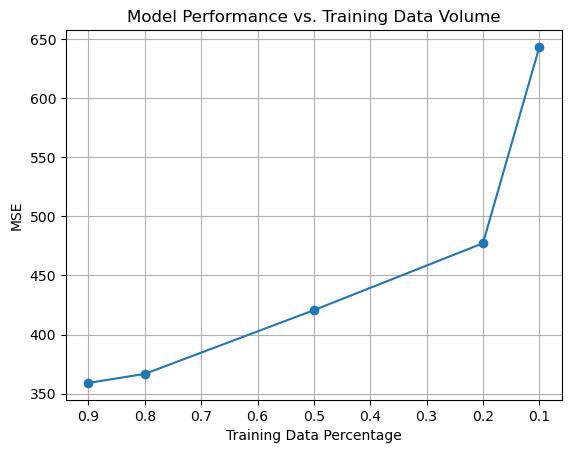

In [235]:
# resutls 2, different percentage training dataset volumne
X_train_final = X_train_final_last.drop(columns=["PATIENT_ID","outcome","t"])
X_test_final = X_test_final_last.drop(columns=["PATIENT_ID","outcome","t"])

def evaluate_different_training_volume(X_train, y_train, X_test, y_test):
    # X_train and X_test needed to be converted to shaoe 375 x 1 x 3
    X_test_ts = X_test.values.reshape(-1,1,3)

    epochs = 400
    batch_size = 32
    lr = 0.001
    pct_list = [0.9, 0.8, 0.5, 0.2, 0.1]  

    mse_scores = []

    for pct in pct_list:
        # select sub dataset but still has shape (n, 3)
        num_rows = int(pct * len(X_train))
        select_idx = np.random.choice(len(X_train), size=num_rows, replace=False)
        X_train_pct = X_train.sample(frac=pct, replace=False, random_state=42)
        select_idx = X_train_pct.index
        y_train_pct = [y_train[i] for i in select_idx]

        # convert to values
        X_train_pct = X_train_pct.values

        # reshape
        X_train_ts = X_train_pct.reshape(-1, 1, 3)
        
        X_train_tensor = torch.tensor(X_train_ts, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train_pct, dtype=torch.float32).unsqueeze(1)
        X_test_tensor = torch.tensor(X_test_ts, dtype=torch.float32)
        y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        model = distcare_target(input_dim = 3,output_dim=output_dim, d_model=d_model, MHD_num_head=MHD_num_head, d_ff=d_ff, hidden_dim=hidden_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)

        for epoch in range(epochs):
            model.train()
            
            for inputs, targets in train_loader:
                batch_x = inputs
                batch_y = targets
                batch_lens = torch.ones(batch_x.size(0), dtype=torch.int64)  # Shape: [number_instances]
                masks = length_to_mask(batch_lens).unsqueeze(-1).float()
                opt, decov_loss, emb = model(batch_x, batch_lens)
                MSE_Loss = get_re_loss(opt, batch_y.unsqueeze(-1))
                model_loss =  MSE_Loss + 1e7*decov_loss
                loss = model_loss
                loss.backward()
                optimizer.step()
        
        # evaluation on test dataset
        model.eval()
        lens = torch.ones(X_test_tensor.size(0), dtype=torch.int64)  # Shape: [number_instances]
        # Inference using the DataLoader
        with torch.no_grad():
            outputs, decov_loss, weighted_contexts = model(X_test_tensor, lens)
            mse = mean_squared_error(y_test_tensor, outputs)
            mae = mean_absolute_error(y_test_tensor, outputs)
            mse_scores.append(mse)
        #print(outputs.shape)  # Should be [batch_size, output_dim]
        print(f"Test MSE: {mse:.4f}")
        print(f"Test MAE: {mae:.4f}")

    return pct_list, mse_scores

# reshpae input size to use pre-trained target model
pct_list, mse_scores = evaluate_different_training_volume(X_train_final, y_train, X_test_final, y_test)

plt.plot(pct_list, mse_scores, marker='o')
plt.gca().invert_xaxis()
plt.xlabel("Training Data Percentage")
plt.ylabel("MSE")
plt.title("Model Performance vs. Training Data Volume")
plt.grid()
plt.show()